In [1]:
%%bash
pip install --upgrade tensorflow-gpu

  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import scipy
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.python.training import training_util

print(tf.__version__)

2.0.0


In [4]:
#Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
##Copy data to local
%%bash
cp '/content/drive/My Drive/Colab Notebooks/TF Keras 2.0 GRIR - CMLE + FeatEngg/GRIR_GCP_Data.csv' 'GRIR_GCP_Data.csv'

In [0]:
df = pd.read_csv("GRIR_GCP_Data.csv", sep=",")

In [7]:
df.head(10)

,WERKS,SCENARIO,KTOKK,VSTATU,VPATD,EKORG,EKGRP,TOTGRQTY,TOTIRQTY,NODLGR,NODLIR,DIFGRIRD,DIFGRIRV,STATUS
0,ML01,3,1,1,30,1,A,0,80,0,90,-80,-38100,1
1,ML01,3,1,1,30,1,A,0,107,0,177,-107,-41600,0
2,ML01,3,1,1,30,1,A,0,107,0,152,-107,-27600,1
3,ML01,3,1,1,30,1,A,0,96,0,79,-96,-13800,1
4,ML01,3,1,1,30,1,A,0,146,0,192,-146,-73500,0
5,ML01,3,1,1,60,1,A,0,189,0,139,-189,-26600,1
6,ML01,3,1,1,60,1,A,0,183,0,48,-183,-69200,0
7,ML01,3,1,1,60,1,A,0,159,0,195,-159,-73600,0
8,ML01,3,1,1,60,1,A,0,185,0,79,-185,-59500,0
9,ML01,3,1,1,60,1,A,0,91,0,168,-91,-4700,1


In [8]:
df.describe()

,SCENARIO,KTOKK,VSTATU,VPATD,EKORG,TOTGRQTY,TOTIRQTY,NODLGR,NODLIR,DIFGRIRD,DIFGRIRV,STATUS
count,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000
mean,2.565286,1.497886,1.119097,60.264525,1.333374,65.938398,94.098563,103.070419,89.499819,-28.160164,-6716.334461,0.391835
std,1.096595,0.500026,0.323922,24.387448,0.471447,62.960829,62.449709,81.968329,75.005213,63.224655,22797.380084,0.488190
min,1.000000,1.000000,1.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-200.000000,-75000.000000,0.000000
25%,2.000000,1.000000,1.000000,30.000000,1.000000,0.000000,54.000000,0.000000,10.000000,-56.000000,-9600.000000,0.000000
50%,3.000000,1.000000,1.000000,60.000000,1.000000,55.000000,99.000000,112.000000,82.000000,-2.000000,-546.000000,0.000000
75%,4.000000,2.000000,1.000000,90.000000,2.000000,121.000000,146.000000,172.000000,154.000000,11.000000,5482.000000,1.000000
max,4.000000,2.000000,2.000000,90.000000,2.000000,200.000000,200.000000,268.000000,242.000000,74.000000,59200.000000,1.000000


In [9]:
df.columns

Index(['WERKS', 'SCENARIO', 'KTOKK', 'VSTATU', 'VPATD', 'EKORG', 'EKGRP',
       'TOTGRQTY', 'TOTIRQTY', 'NODLGR', 'NODLIR', 'DIFGRIRD', 'DIFGRIRV',
       'STATUS'],
      dtype='object')

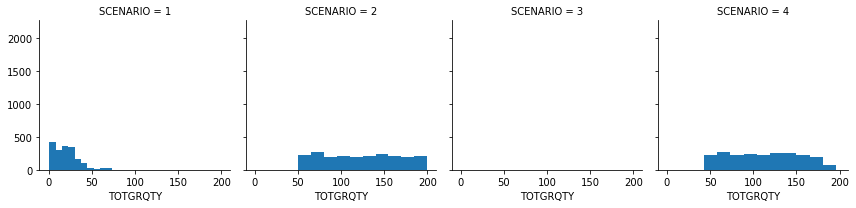

In [10]:
#Facet1
g = sns.FacetGrid(df, col="SCENARIO")
g = g.map(plt.hist, "TOTGRQTY")
plt.show()

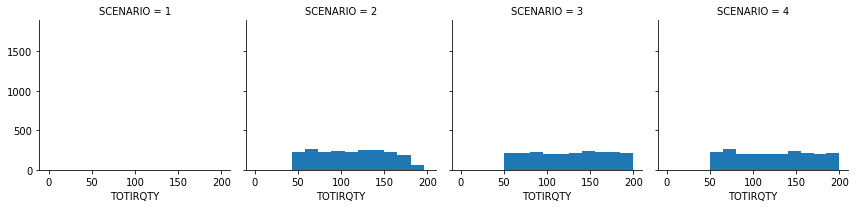

In [11]:
#Facet1
g = sns.FacetGrid(df, col="SCENARIO")
g = g.map(plt.hist, "TOTIRQTY")
plt.show()

In [12]:
#Filter out scenario = 3 ( It has TOTGRQTY == 0 )
df_s1 = df[df['SCENARIO'].eq(3) & df['TOTGRQTY'].eq(0)]
df_s1.head()

,WERKS,SCENARIO,KTOKK,VSTATU,VPATD,EKORG,EKGRP,TOTGRQTY,TOTIRQTY,NODLGR,NODLIR,DIFGRIRD,DIFGRIRV,STATUS
0,ML01,3,1,1,30,1,A,0,80,0,90,-80,-38100,1
1,ML01,3,1,1,30,1,A,0,107,0,177,-107,-41600,0
2,ML01,3,1,1,30,1,A,0,107,0,152,-107,-27600,1
3,ML01,3,1,1,30,1,A,0,96,0,79,-96,-13800,1
4,ML01,3,1,1,30,1,A,0,146,0,192,-146,-73500,0


In [13]:
#Mark some columns as categorical so that TF treats them as categorical
for col_cat in ['SCENARIO','KTOKK','VSTATU','EKORG']:
    df[col_cat] = df[col_cat].astype('str') #Very important to keep this as STR -> Tensorflow treats only STR as categorical
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8279 entries, 0 to 8278
Data columns (total 14 columns):
WERKS       8279 non-null object
SCENARIO    8279 non-null object
KTOKK       8279 non-null object
VSTATU      8279 non-null object
VPATD       8279 non-null int64
EKORG       8279 non-null object
EKGRP       8279 non-null object
TOTGRQTY    8279 non-null int64
TOTIRQTY    8279 non-null int64
NODLGR      8279 non-null int64
NODLIR      8279 non-null int64
DIFGRIRD    8279 non-null int64
DIFGRIRV    8279 non-null int64
STATUS      8279 non-null int64
dtypes: int64(8), object(6)
memory usage: 905.6+ KB


In [14]:
#Split dataset -> Split 10 times and choose the one with best P values( Significance test )
p_res = {}
t_res = []
for i in range(10):
    np.random.seed(seed=i) #makes result reproducible
    msk = np.random.rand(len(df)) < 0.8
    X_train = df[msk]
    X_test = df[~msk]

    #Run Significance Tests on both the distributions( Train and Test ) for all numerical attributes
    p_res = {}
    for c_ in X_train.columns:
        if not X_train[c_].dtype == 'object':
            try:
                _, a = scipy.stats.ks_2samp(X_train[c_].values,X_test[c_].values)
                #print('P-value for column {} is {}'.format(c_.upper(), a))
                p_res['Random'] = i
                p_res[c_] = a
            except:
                p_res['Random'] = i
                p_res[c_] = 'Error'
    t_res.append(p_res)

p_df = pd.DataFrame(t_res)
p_df

,Random,VPATD,TOTGRQTY,TOTIRQTY,NODLGR,NODLIR,DIFGRIRD,DIFGRIRV,STATUS
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
#Prepare train and test data set
np.random.seed(seed=2) #makes result reproducible
msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
evaldf = df[~msk]
#evaldf[evaldf['STATUS'] == 1]

In [16]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6629 entries, 0 to 8278
Data columns (total 14 columns):
WERKS       6629 non-null object
SCENARIO    6629 non-null object
KTOKK       6629 non-null object
VSTATU      6629 non-null object
VPATD       6629 non-null int64
EKORG       6629 non-null object
EKGRP       6629 non-null object
TOTGRQTY    6629 non-null int64
TOTIRQTY    6629 non-null int64
NODLGR      6629 non-null int64
NODLIR      6629 non-null int64
DIFGRIRD    6629 non-null int64
DIFGRIRV    6629 non-null int64
STATUS      6629 non-null int64
dtypes: int64(8), object(6)
memory usage: 776.8+ KB


In [17]:
evaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 16 to 8272
Data columns (total 14 columns):
WERKS       1650 non-null object
SCENARIO    1650 non-null object
KTOKK       1650 non-null object
VSTATU      1650 non-null object
VPATD       1650 non-null int64
EKORG       1650 non-null object
EKGRP       1650 non-null object
TOTGRQTY    1650 non-null int64
TOTIRQTY    1650 non-null int64
NODLGR      1650 non-null int64
NODLIR      1650 non-null int64
DIFGRIRD    1650 non-null int64
DIFGRIRV    1650 non-null int64
STATUS      1650 non-null int64
dtypes: int64(8), object(6)
memory usage: 193.4+ KB


In [0]:
#Files To be used in Tensorflow pipeline dataset API
traindf.to_csv("grir_train.csv", index=False, header=False)
evaldf.to_csv("grir_eval.csv", index=False, header=False)

In [0]:
######################################## Tensorflow Pipeline building and Modeling ############################################

In [0]:
def feature_engg_features(features):
  #Add new features
  features['grminusirbyvpatd'] = ( features['TOTGRQTY'] - features['TOTIRQTY'] ) / features['VPATD']

  return(features)

def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)

In [23]:
traindf.columns

Index(['WERKS', 'SCENARIO', 'KTOKK', 'VSTATU', 'VPATD', 'EKORG', 'EKGRP',
       'TOTGRQTY', 'TOTIRQTY', 'NODLGR', 'NODLIR', 'DIFGRIRD', 'DIFGRIRV',
       'STATUS'],
      dtype='object')

In [0]:
# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'STATUS'

# Set default values for each CSV column( Including Y column )
DEFAULTS = [["ML01"], ['0'], ['0'],["0"],[-1],["-1"],["-1"],[0],[0],[0],[0],[0],[0],[0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)
        dataset = dataset.prefetch(buffer_size = batch_size)
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          x, y = dataset.make_one_shot_iterator().get_next()
          #TF 2.0 has eager execution
          print(x, y)
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

# Serving function for external call
["ML01"], ['0'], ['0'],["0"],[-1],["-1"],["-1"],[0],[0],[0],[0],[0],[0],[0]
def serving_fn():
    feature_placeholders  = {'WERKS' : tf.compat.v1.placeholder_with_default("ML01", None),
            'SCENARIO' : tf.compat.v1.placeholder_with_default("0", None),
            'KTOKK' : tf.compat.v1.placeholder_with_default("0", None),
            'VSTATU' : tf.compat.v1.placeholder_with_default("0", None),
            'EKORG' : tf.compat.v1.placeholder_with_default("0", None),
            'EKGRP' : tf.compat.v1.placeholder_with_default("0", None),
            'VPATD' : tf.compat.v1.placeholder_with_default(0, None),
            'TOTGRQTY' : tf.compat.v1.placeholder_with_default(0, None),
            'TOTIRQTY' : tf.compat.v1.placeholder_with_default(0, None),
            'NODLGR' : tf.compat.v1.placeholder_with_default(0, None),
            'NODLIR' : tf.compat.v1.placeholder_with_default(0, None),
            'DIFGRIRD' : tf.compat.v1.placeholder_with_default(0, None),
            'DIFGRIRV' : tf.compat.v1.placeholder_with_default(0, None)
    }

    #Features with transformation logic
    features = {
                key: tf.expand_dims(tensor, -1)
                for key, tensor in feature_placeholders.items()
            }
    
    #feat_changed = add_engineered(features.copy())
    return tf.estimator.export.ServingInputReceiver(feature_engg_features(features), feature_placeholders )

In [58]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = "*eval*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.TRAIN,
                    vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

OrderedDict([('WERKS', <tf.Tensor: id=11254, shape=(10,), dtype=string, numpy=
array([b'ML01', b'ML02', b'ML03', b'ML01', b'ML02', b'ML03', b'ML01',
       b'ML02', b'ML01', b'ML03'], dtype=object)>), ('SCENARIO', <tf.Tensor: id=11249, shape=(10,), dtype=string, numpy=
array([b'2', b'3', b'1', b'1', b'3', b'2', b'2', b'3', b'3', b'1'],
      dtype=object)>), ('KTOKK', <tf.Tensor: id=11246, shape=(10,), dtype=string, numpy=
array([b'2', b'2', b'2', b'1', b'2', b'1', b'2', b'2', b'2', b'1'],
      dtype=object)>), ('VSTATU', <tf.Tensor: id=11253, shape=(10,), dtype=string, numpy=
array([b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1'],
      dtype=object)>), ('VPATD', <tf.Tensor: id=11252, shape=(10,), dtype=int32, numpy=array([30, 90, 30, 90, 30, 30, 30, 60, 90, 30], dtype=int32)>), ('EKORG', <tf.Tensor: id=11245, shape=(10,), dtype=string, numpy=
array([b'1', b'1', b'2', b'1', b'1', b'2', b'1', b'1', b'1', b'2'],
      dtype=object)>), ('EKGRP', <tf.Tensor: id=11244, shape=(

<DatasetV1Adapter shapes: (OrderedDict([(WERKS, (None,)), (SCENARIO, (None,)), (KTOKK, (None,)), (VSTATU, (None,)), (VPATD, (None,)), (EKORG, (None,)), (EKGRP, (None,)), (TOTGRQTY, (None,)), (TOTIRQTY, (None,)), (NODLGR, (None,)), (NODLIR, (None,)), (DIFGRIRD, (None,)), (DIFGRIRV, (None,)), (grminusirbyvpatd, (None,))]), (None,)), types: (OrderedDict([(WERKS, tf.string), (SCENARIO, tf.string), (KTOKK, tf.string), (VSTATU, tf.string), (VPATD, tf.int32), (EKORG, tf.string), (EKGRP, tf.string), (TOTGRQTY, tf.int32), (TOTIRQTY, tf.int32), (NODLGR, tf.int32), (NODLIR, tf.int32), (DIFGRIRD, tf.int32), (DIFGRIRV, tf.int32), (grminusirbyvpatd, tf.float64)]), tf.int32)>

In [0]:
# Define your feature columns
def create_feature_cols():
#   lat_buck = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('latitude'), 
#                                                  boundaries = np.arange(32.0, 42, 1).tolist())
#   long_buck = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('longitude'),
#                                                   boundaries = np.arange(1, 52, 1).tolist())
    werks_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='WERKS',
            vocabulary_list=['ML01','ML02','ML03'])
    scenario_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='SCENARIO',
            vocabulary_list=['1','2','3','4'])
    ktokk_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='KTOKK',
            vocabulary_list=['1','2'])    
    vstatu_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='VSTATU',
            vocabulary_list=['1','2'])
    ekorg_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='EKORG',
            vocabulary_list=['1','2'])   
    ekgrp_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='EKGRP',
            vocabulary_list=['A','B','C'])
    
#     werks_c = tf.feature_column.categorical_column_with_hash_bucket(
#             key='WERKS',hash_bucket_size=3)
#     scenario_c = tf.feature_column.categorical_column_with_hash_bucket(
#             key='SCENARIO',hash_bucket_size=4)
#     ktokk_c = tf.feature_column.categorical_column_with_hash_bucket(
#             key='KTOKK',hash_bucket_size=2)
#     vstatu_c = tf.feature_column.categorical_column_with_hash_bucket(
#             key='VSTATU',hash_bucket_size=2)
#     ekorg_c = tf.feature_column.categorical_column_with_hash_bucket(
#             key='EKORG',hash_bucket_size=2)
#     ekgrp_c = tf.feature_column.categorical_column_with_hash_bucket(
#             key='EKGRP',hash_bucket_size=3)

    return [
        tf.feature_column.indicator_column(werks_c),
        tf.feature_column.indicator_column(scenario_c),
        tf.feature_column.indicator_column(ktokk_c),
        tf.feature_column.indicator_column(vstatu_c),
        tf.feature_column.indicator_column(ekorg_c),
        tf.feature_column.indicator_column(ekgrp_c),
        tf.feature_column.numeric_column('VPATD'),
        tf.feature_column.numeric_column("TOTGRQTY"),
        tf.feature_column.numeric_column("TOTIRQTY"),
        tf.feature_column.numeric_column("NODLGR"),
        tf.feature_column.numeric_column("NODLIR"),
        tf.feature_column.numeric_column("DIFGRIRD"),
        tf.feature_column.numeric_column("grminusirbyvpatd"),
        tf.feature_column.numeric_column("DIFGRIRV")
  ]

In [0]:
# Create estimator train and evaluate function
def train_and_evaluate(output_dir, num_train_steps, train_file, eval_file):    
##### Create Canned estimator instance
    ## setting the checkpoint interval to be much lower for this task
    run_config = tf.estimator.RunConfig(save_checkpoints_secs = 40, 
                                        keep_checkpoint_max = 3)
    
    estimator = tf.estimator.DNNClassifier(feature_columns=create_feature_cols(),
                                          n_classes=2,
                                          hidden_units=[32,32],
                                          dropout = 0.2,
                                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
#                                           config = run_config)
    train_spec = tf.estimator.TrainSpec(input_fn = make_input_fn(
                                                filename = train_file,
                                                mode = tf.estimator.ModeKeys.TRAIN,
                                                batch_size = 128),
                                      max_steps = num_train_steps)
    exp = tf.estimator.LatestExporter("decision", serving_fn)
    eval_spec = tf.estimator.EvalSpec(input_fn = make_input_fn(
                                                filename = eval_file,
                                                mode = tf.estimator.ModeKeys.EVAL,
                                                batch_size = 128),
                                    steps = None, 
                                    exporters = exp,
                                    start_delay_secs = 20, # start evaluating after N seconds, 
                                    throttle_secs = 45)  # evaluate every N seconds
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [0]:
train_file = "*train*.csv"
eval_file = "*eval*.csv"

In [62]:
#Final trainer
train_and_evaluate(None, num_train_steps=1000, train_file=train_file, eval_file=eval_file)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_zvo8y5r', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4ac694bb70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:t

In [0]:
# #Only DNN Deep wide classifier
# def get_deep_wide_features():
#     werks_c = tf.feature_column.categorical_column_with_vocabulary_list(
#             key='WERKS',
#             vocabulary_list=['ML01','ML02','ML03'])
#     scenario_c = tf.feature_column.categorical_column_with_vocabulary_list(
#             key='SCENARIO',
#             vocabulary_list=['1','2','3','4'])
#     ktokk_c = tf.feature_column.categorical_column_with_vocabulary_list(
#             key='KTOKK',
#             vocabulary_list=['1','2'])    
#     vstatu_c = tf.feature_column.categorical_column_with_vocabulary_list(
#             key='VSTATU',
#             vocabulary_list=['1','2'])
#     ekorg_c = tf.feature_column.categorical_column_with_vocabulary_list(
#             key='EKORG',
#             vocabulary_list=['1','2'])   
#     ekgrp_c = tf.feature_column.categorical_column_with_vocabulary_list(
#             key='EKGRP',
#             vocabulary_list=['A','B','C'])
#     deep_columns = [
#         tf.feature_column.numeric_column('VPATD'),
#         tf.feature_column.numeric_column("TOTGRQTY"),
#         tf.feature_column.numeric_column("TOTIRQTY"),
#         tf.feature_column.numeric_column("NODLGR"),
#         tf.feature_column.numeric_column("NODLIR"),
#         tf.feature_column.numeric_column("DIFGRIRD"),
#         tf.feature_column.numeric_column("DIFGRIRV")
#     ]
#     wide_columns = [
#         tf.feature_column.indicator_column(werks_c),
#         tf.feature_column.indicator_column(scenario_c),
#         tf.feature_column.indicator_column(ktokk_c),
#         tf.feature_column.indicator_column(vstatu_c),
#         tf.feature_column.indicator_column(ekorg_c),
#         tf.feature_column.indicator_column(ekgrp_c),
#     ]
#     return deep_columns, wide_columns

# def train_and_evaluate_deep(output_dir, num_train_steps):    
# ##### Create Canned estimator instance
#     #Get features
#     deep, wide = get_deep_wide_features()

#     estimator = tf.estimator.DNNLinearCombinedClassifier(
#                                     linear_feature_columns = wide,
#                                     dnn_feature_columns = deep,
#                                     n_classes=2,
#                                     dnn_hidden_units = [32,64,64,64,64,64,
#                                                         64,64,64,64,64,64,
#                                                         64,64,64,64,64,64,
#                                                         32],
#                                     dnn_dropout = 0.1,
#                                     dnn_optimizer=tf.train.AdamOptimizer(learning_rate=0.0001))
#     train_spec = tf.estimator.TrainSpec(input_fn = make_input_fn(traindf, None), 
#                                       max_steps = num_train_steps)
#     exp = tf.estimator.LatestExporter("decision", serving_fn)
#     eval_spec = tf.estimator.EvalSpec(input_fn = make_input_fn(evaldf, 1), 
#                                     steps = None, 
#                                     exporters = exp,
#                                     start_delay_secs = 1, # start evaluating after N seconds, 
#                                     throttle_secs = 40)  # evaluate every N seconds
#     tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [0]:
# #setup exponential decay function for learning rates
# def get_global_step():
#     if tf.train.get_global_step() is None:
#         return 1
#     else:
#         return tf.train.get_global_step()

# def get_exp_decay_optimizer():
#     def exp_decay(global_step=global_step):
#         return tf.train.exponential_decay(
#           learning_rate=0.0001, global_step=global_step,
#           decay_steps=100, decay_rate=0.8, staircase=True)
#     # use customized decay function in learning_rate
#     return tf.train.AdagradOptimizer(learning_rate=exp_decay(tf.train.get_global_step()))

# # setup stepwise decay function for learning rates
# def get_stepw_decay_optimizer2():
#     def step_decay():
#         return tf.train.piecewise_constant(get_global_step(), 
#                                            boundaries=[10000,20000,50000,100000], 
#                                            values=[0.001,0.0005,0.0001,0.00005,0.00002])
#     # use customized decay function in learning_rate
#     return tf.train.AdamOptimizer(learning_rate=step_decay)#,epsilon=0.001)

# # setup stepwise decay function for learning rates
# def get_stepw_decay_optimizer():
#     def step_decay(global_step):
#         return tf.train.piecewise_constant(global_step, boundaries=[10000,20000,50000,100000], values=[0.001,0.0005,0.0001,0.00005,0.00002])
#                                          # use customized decay function in learning_rate
#     return tf.train.AdamOptimizer(learning_rate=step_decay(tf.train.get_global_step()))#,epsilon=0.001)

In [0]:
accuracy_score = classifier.evaluate(input_fn=get_input_fn(training_set, num_epochs=1, shuffle=False))["accuracy"]
print("\nTrain Accuracy: {0:f}\n".format(accuracy_score))

In [0]:
accuracy_score = classifier.evaluate(input_fn=get_validation_input_fn(test_set, num_epochs=1, shuffle=False))["accuracy"]
print("\nTest Accuracy: {0:f}\n".format(accuracy_score))

In [0]:
#Run model on Prediction data set
predictions = classifier.predict_classes(input_fn=get_prediction_input_fn(test_set))
for p in list(predictions):
    print(p)

In [0]:
for i in list(test_set['STATUS']):
    print(i)

In [0]:
#Predict with disk saved model
from tensorflow.contrib import predictor

export_dir = os.getcwd() + "/tflow_grir_model"
predict_fn = predictor.from_saved_model(export_dir,signature_def_key='predict')

predictions = predict_fn({"DIFGRIRV": [-38100],"NODLIR": [90],"VSTATU": ["1"],"NODLGR": [0],"DIFGRIRD": [-80],"VPATD": [30],
                          "WERKS": ["ML01"],
                          "EKORG": ["1"],"TOTGRQTY": [0],"SCENARIO": ["3"],"TOTIRQTY": [80],"KTOKK": ["1"],"EKGRP": ["A"]})
print(predictions['probabilities'][0,1])